In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pylab import rcParams

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

In [171]:
rcParams['figure.figsize'] = 15, 6

In [172]:
path_matlab = "../../data/series/series_matlab.csv"
path_fires = "../../data/series/series_fires_acre.csv"

series_matlab = pd.read_csv(path_matlab)
series_fires = pd.read_csv(path_fires, encoding='ISO-8859-1')

In [173]:
series_matlab

,month,matlab
0,2009-01-31,19
1,2009-02-28,27
2,2009-03-31,24
3,2009-04-30,32
4,2009-05-31,42
...,...,...
127,2019-08-31,371
128,2019-09-30,362
129,2019-10-31,523
130,2019-11-30,479


In [174]:
series_matlab['month'] = pd.to_datetime(series_matlab['month'])

In [175]:
series_matlab = series_matlab.set_index('month')

<Axes: xlabel='month'>

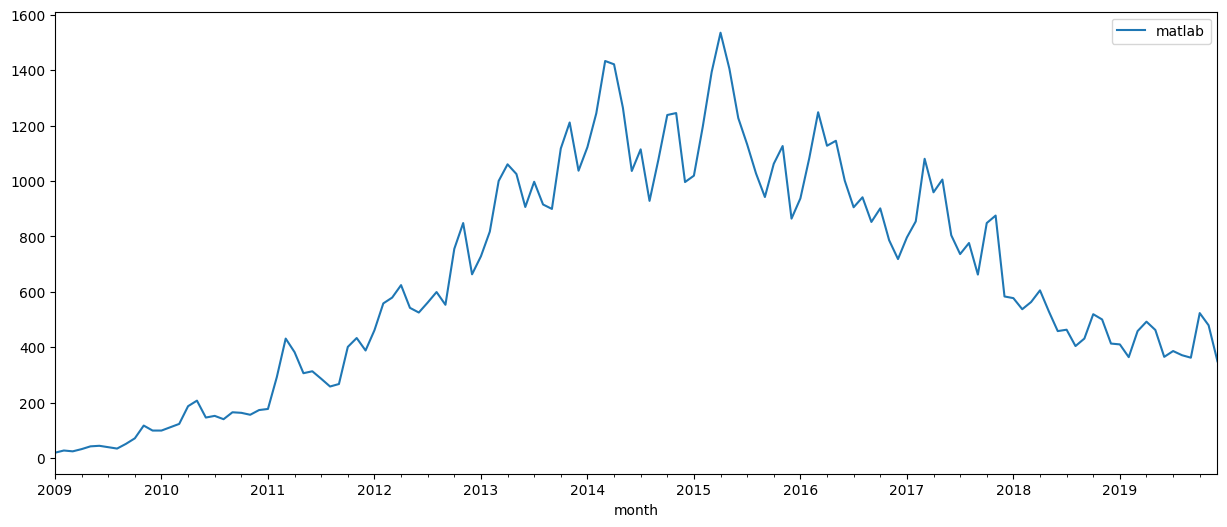

In [176]:
series_matlab.plot()

In [177]:
train_matlab, val_matlab, test_matlab = series_matlab.loc['2009':'2016'], series_matlab.loc['2017'], series_matlab.loc['2018':'2019']

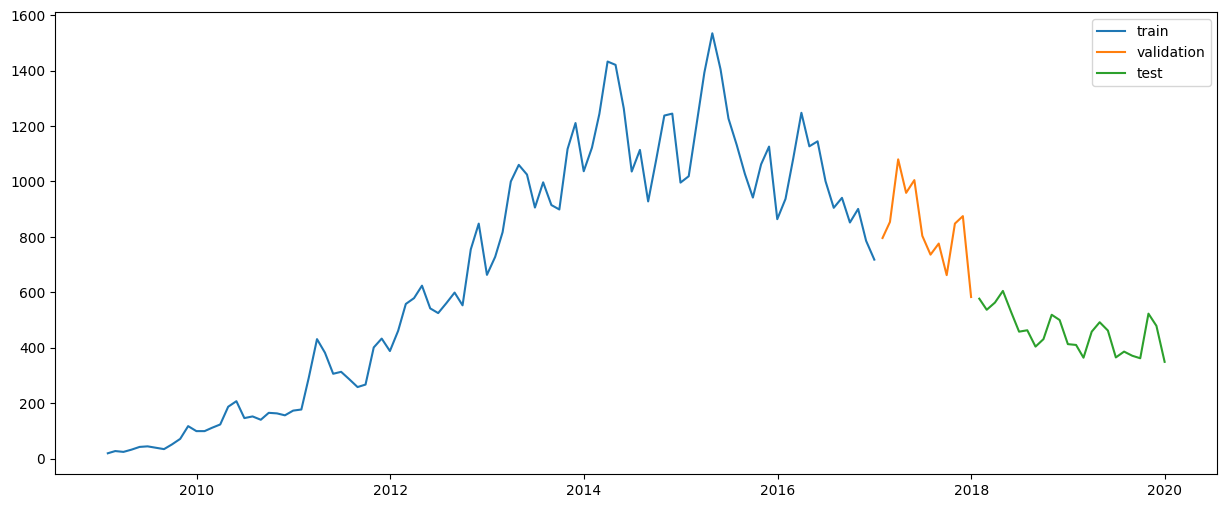

In [178]:
plt.plot(train_matlab, label = 'train')
plt.plot(val_matlab, label = 'validation')
plt.plot(test_matlab, label = 'test')
plt.legend(loc = 'best')
plt.show()

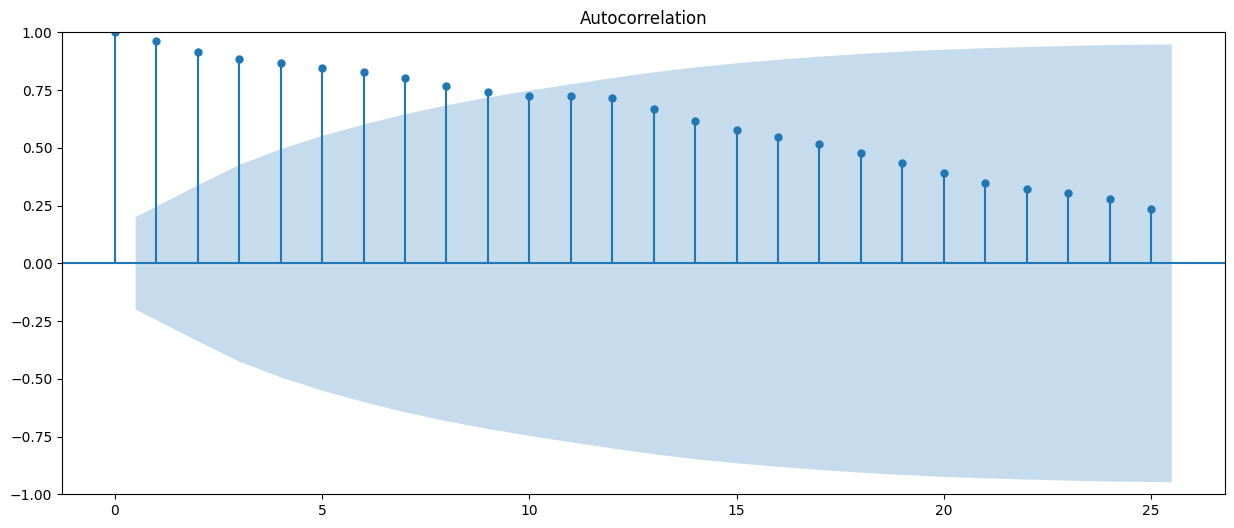

In [179]:
sm.graphics.tsa.plot_acf(train_matlab, lags=25)
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


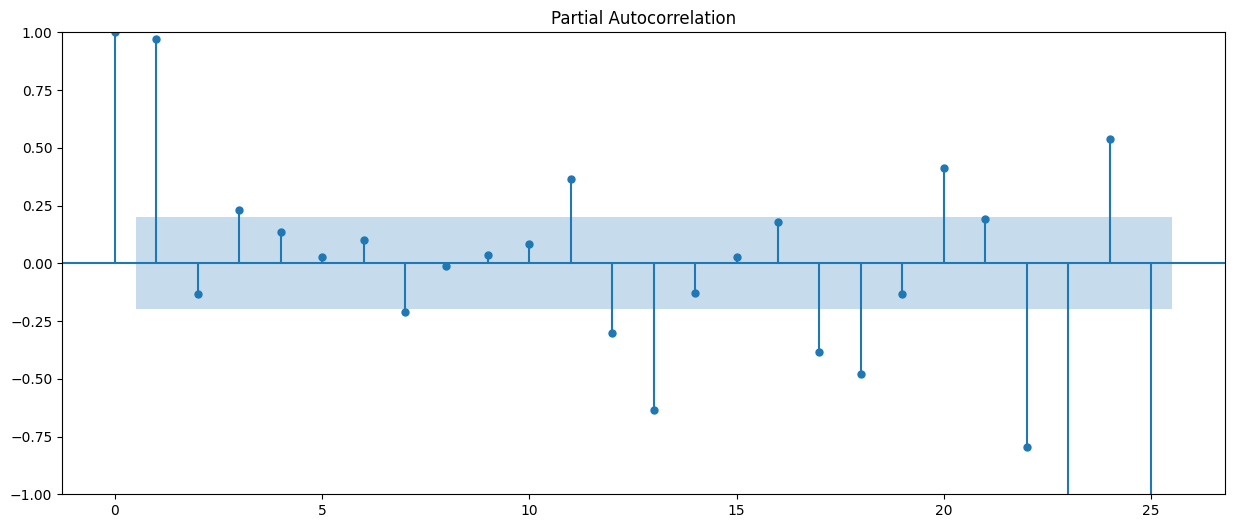

In [180]:
fig = sm.graphics.tsa.plot_pacf(train_matlab, lags=25)
plt.show()

In [181]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [182]:
train_windows = create_sliding_windows(train_matlab, 9)
val_windows = create_sliding_windows(val_matlab, 9)
test_windows = create_sliding_windows(test_matlab, 9)

In [183]:
train_windows.shape

(87, 10)

In [184]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1]

## Decision Tree Regressor

In [185]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]


best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m)
      modelo.fit(X_train, y_train)
      prev_val = modelo.predict(X_val)

      mse = MSE(y_val, prev_val)
      if mse < best_mse:
        best_mse = mse
        best_criterion = c
        best_splitter = s
        best_depth = m


In [186]:
best_mse

10079.333333333334

In [187]:
(best_criterion, best_splitter, best_depth, best_mse)

('squared_error', 'random', 20, 10079.333333333334)

In [188]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [189]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

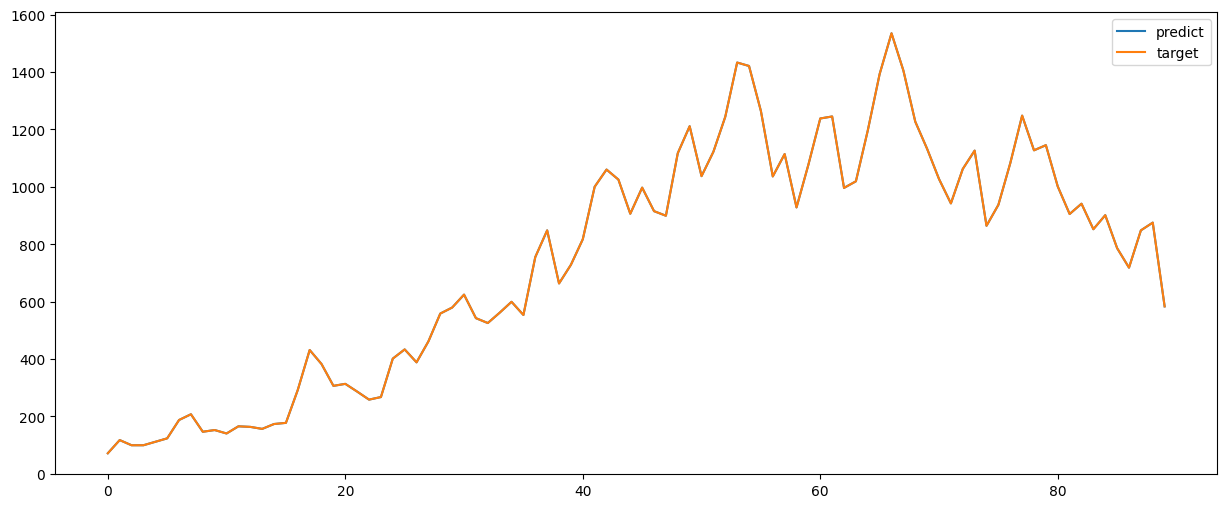

In [190]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [191]:
MSE(y_train_full, prev_train)

0.0

In [192]:
prev_test = modelo.predict(X_test)

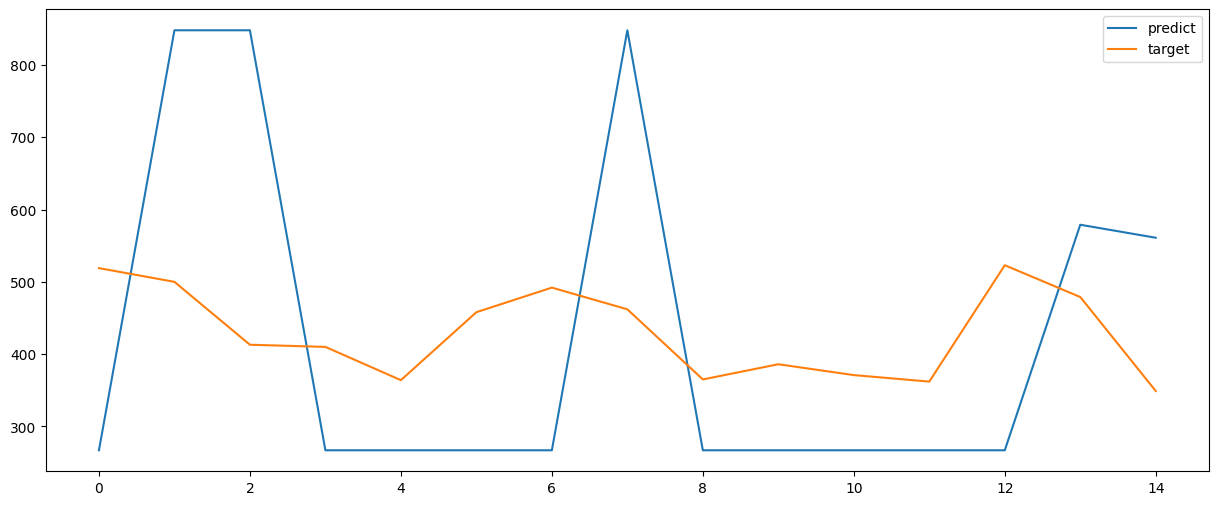

In [193]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [121]:
MSE(y_test, prev_test)

27286.6

### Cross Time Validation

In [44]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Definindo o número de divisões para a validação cruzada no tempo
n_splits = 5

# Criando o objeto TimeSeriesSplit para a validação cruzada
tscv = TimeSeriesSplit(n_splits=n_splits)

# Inicializando listas para armazenar as previsões de treinamento e teste
prev_train_cv = []
prev_test_cv = []

# Iterando sobre as divisões da validação cruzada
for train_index, test_index in tscv.split(X_train_full):
    X_train_cv, X_test_cv = X_train_full[train_index], X_train_full[test_index]
    y_train_cv, y_test_cv = y_train_full[train_index], y_train_full[test_index]
    
    # Criando e treinando o modelo
    modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth)
    modelo.fit(X_train_cv, y_train_cv)
    
    # Realizando previsões
    prev_train_cv.append(modelo.predict(X_train_cv))
    prev_test_cv.append(modelo.predict(X_test_cv))

# Convertendo as listas de previsões em arrays
prev_train_cv = np.concatenate(prev_train_cv)
prev_test_cv = np.concatenate(prev_test_cv)

# Calculando as previsões no conjunto de teste final
modelo.fit(X_train_full, y_train_full)
prev_train_final = modelo.predict(X_train_full)
prev_test_final = modelo.predict(X_test)



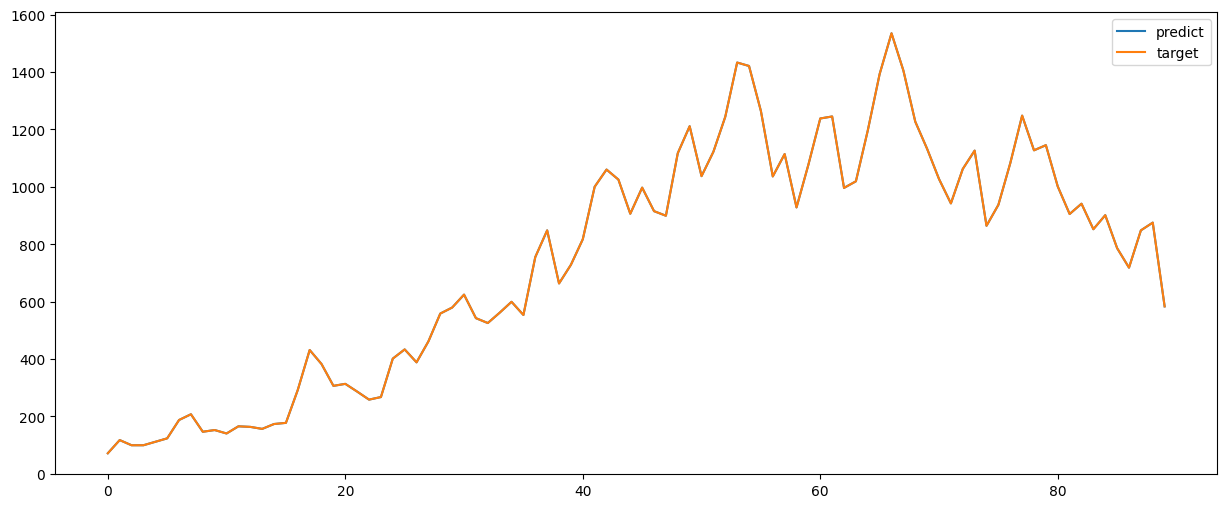

In [45]:
plt.plot(prev_train_final, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

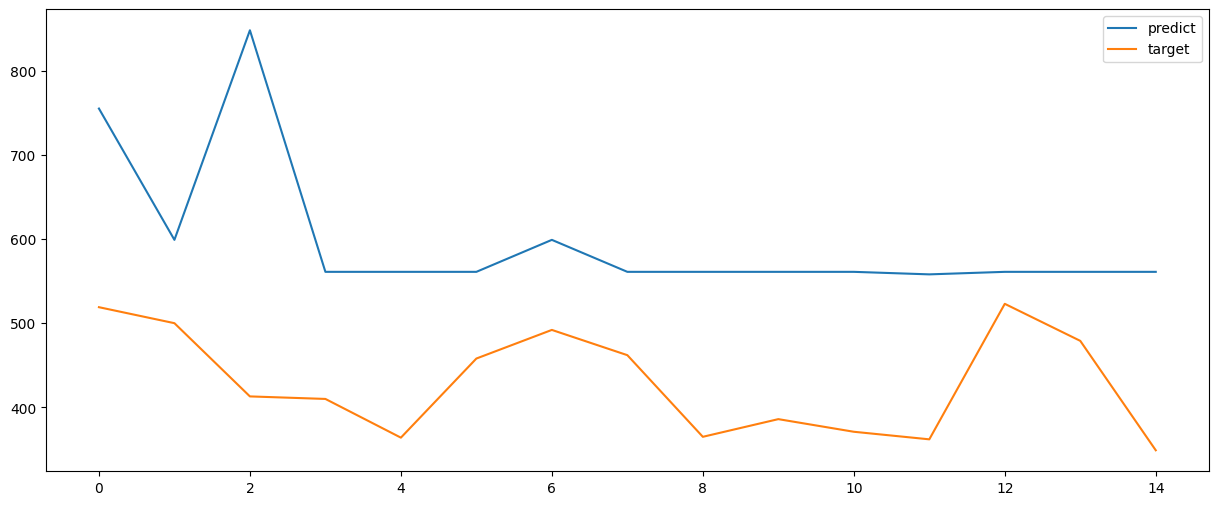

In [46]:
plt.plot(prev_test_final, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

## SVR

In [44]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
gammas = ['scale', 'auto']
# shrinkings = [True, False]
# verboses = [True, False]

best_mse = np.inf
best_kernels = None
best_gammas = None
# best_shrinkings = None
# best_verbose = None

for k in kernels:
  for g in gammas:
    # for s in shrinkings:
    #   for v in verboses:
    modelo = SVR(kernel=k, gamma=g)
    modelo.fit(X_train, y_train)
    prev_val = modelo.predict(X_val)

    mse = MSE(y_val, prev_val)
    if mse < best_mse:
        best_mse = mse
        best_kernels = k
        best_gammas = g
        # best_shrinkings = s
        # best_verbose = v

In [ ]:
(best_kernels, best_gammas, best_mse)

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [ ]:
modelo = SVR(kernel=best_kernels, gamma=best_gammas)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

In [ ]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [ ]:
MSE(y_train_full, prev_train)

In [ ]:
prev_test = modelo.predict(X_test)

In [ ]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [ ]:
MSE(y_test, prev_test)

## MLPRegressor

In [26]:
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

best_mse = np.inf
best_activation = None
best_solver = None
best_learning_rate = None

for a in activation:
  for s in solver:
    for l in learning_rate:
        try:
           
          modelo = MLPRegressor(activation=a, solver=s, learning_rate=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)
        
        except:
           print(a,s,l)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_activation = a
            best_solver = s
            best_learning_rate = l

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_base.py:173: Run

identity sgd constant
identity sgd invscaling


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


identity sgd adaptive


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perce

In [27]:
(best_activation, best_solver, best_learning_rate, best_mse)

('relu', 'lbfgs', 'constant', 9828.705948150628)

In [28]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [29]:
modelo = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


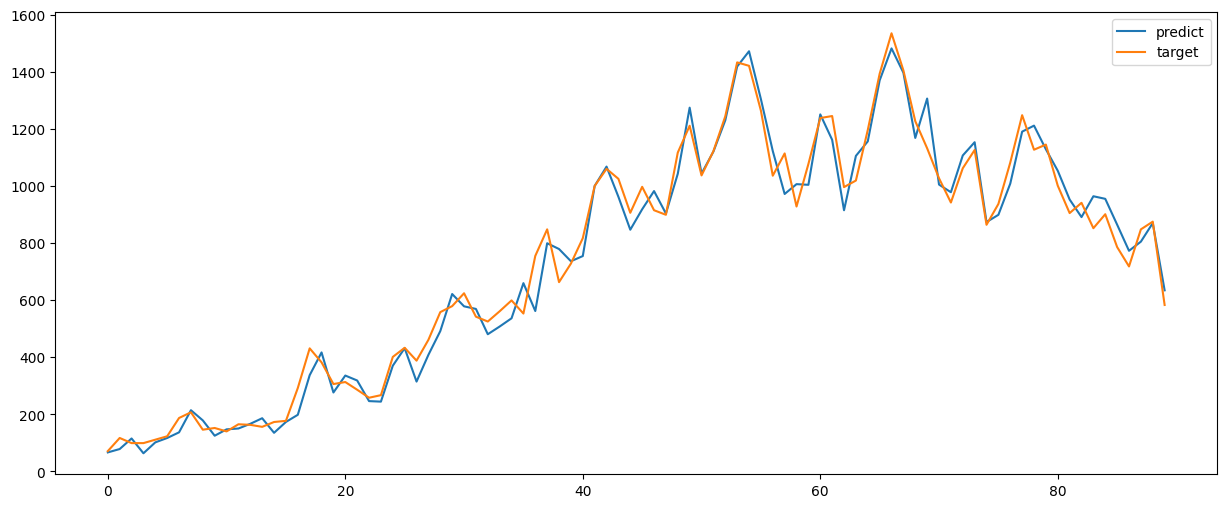

In [30]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [31]:
MSE(y_train_full, prev_train)

3532.980191367137

In [32]:
prev_test = modelo.predict(X_test)

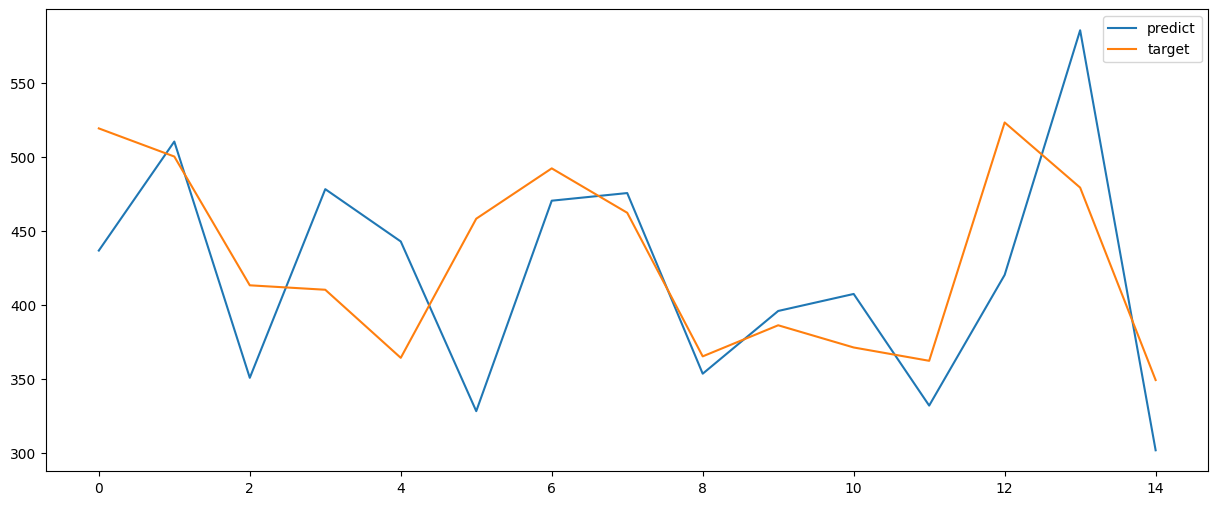

In [33]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [34]:
MSE(y_test, prev_test)

4385.5132086895455

## KNeighborsRegressor

In [35]:
neighbors = [1,2,3,4,5,10,20,30,40,50]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

best_mse = np.inf
best_neighbors = None
best_weights = None
best_algorithm = None

for n in neighbors:
  for w in weights:
    for a in algorithm:
        modelo = KNeighborsRegressor(n_neighbors=n, weights=w, algorithm=a)
        modelo.fit(X_train, y_train)
        prev_val = modelo.predict(X_val)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_neighbors = n
            best_weights = w
            best_algorithm = a

In [36]:
(best_neighbors, best_weights, best_algorithm, best_mse)

(4, 'distance', 'auto', 53876.763932957)

In [37]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [38]:
modelo = KNeighborsRegressor(n_neighbors=best_neighbors, weights=best_weights, algorithm=best_algorithm)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

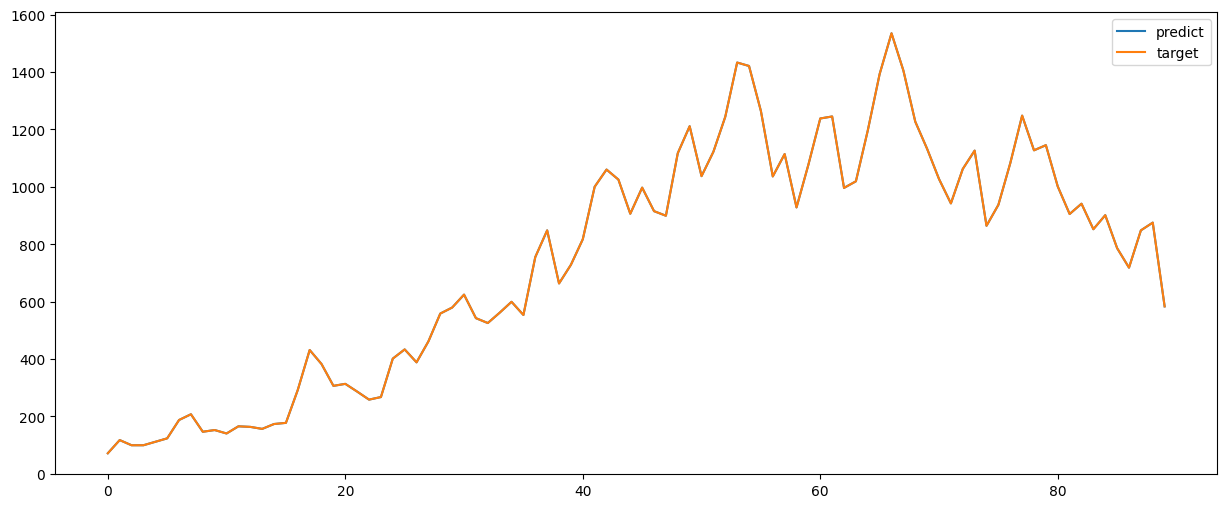

In [39]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [40]:
MSE(y_train_full, prev_train)

0.0

In [41]:
prev_test = modelo.predict(X_test)

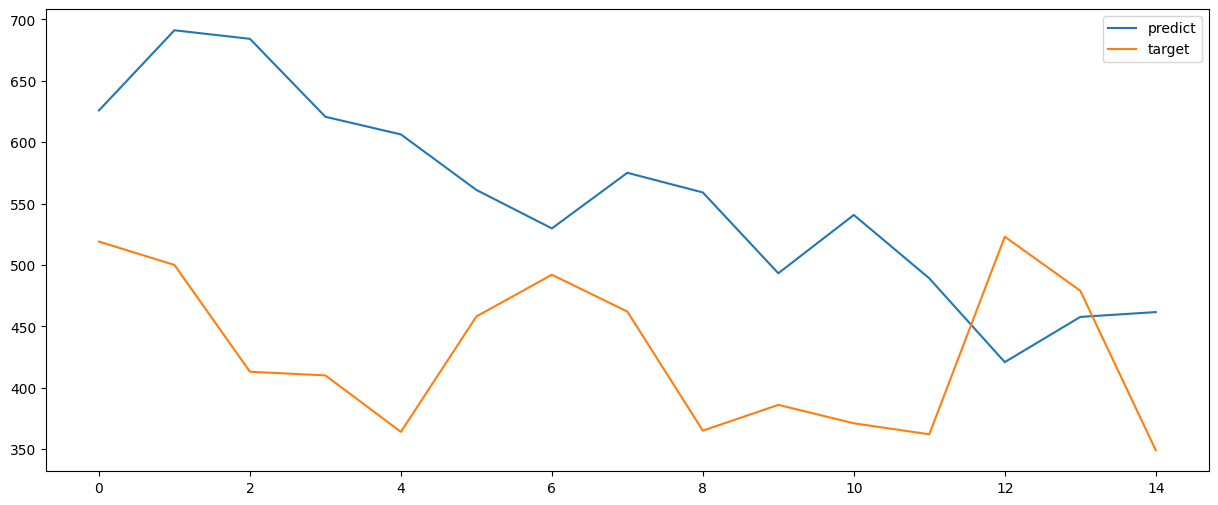

In [42]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [43]:
MSE(y_test, prev_test)

24470.5001564858